# COMP-SCI 5567 — Faster R-CNN (Siamese Model) Pipeline (Project)
Ailing Nan | Jim Huynh | Joseph Marinello | Kenny Phan

In [1]:
# Mount users Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the root folder withing your Google Drive for this project (!User must change based on their own setup!)
PROJECT_PATH = "/content/drive/MyDrive/Deep_Learning/Final Project"

In [3]:
# Unzip the Market-1501 Dataset
import zipfile
from tqdm import tqdm

zip_path = f"{PROJECT_PATH}/Market_1501.zip" # Ensure the zip file is in the root project folder
dest_dir = PROJECT_PATH

# Open zip and extract with progress bar
with zipfile.ZipFile(zip_path, 'r') as zf:
    for member in tqdm(zf.infolist(), desc="Unzipping"):
        zf.extract(member, dest_dir)

Unzipping: 100%|██████████| 136084/136084 [12:52<00:00, 176.07it/s]


In [4]:
# All Imports
import os
import torch
import random
#
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
#
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.io import read_image, write_jpeg

In [5]:
# Set All Seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

Training...
Running on CUDA


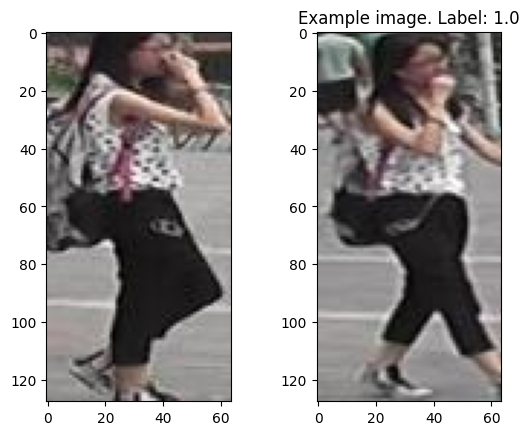

Epoch [1/6], Loss: 13.217682838439941


Epoch [2/6], Loss: 9.165432929992676


Epoch [3/6], Loss: 7.6144914627075195


Epoch [4/6], Loss: 6.478341579437256


Epoch [5/6], Loss: 5.549224853515625


Epoch [6/6], Loss: 4.824512481689453

Testing...
Accuracy: 89.90%
Accuracy: 91.77%
Accuracy: 85.02%


In [6]:
# Siamese Network - pass 2 inputs into the same network and compare the outputs
# to determine if they are the same or different
class Siamese_Network(torch.nn.Module):
    def __init__(self):
        super(Siamese_Network, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=3)
        self.conv3 = torch.nn.Conv2d(128, 128, kernel_size=3)

        # Use dummy input to compute output size
        dummy_input = torch.zeros(1, 3, 128, 64)
        out = self._forward_conv(dummy_input)
        self.flattened_size = out.view(-1).shape[0]

        self.fc1 = torch.nn.Linear(self.flattened_size, 256)
        self.fc2 = torch.nn.Linear(256, 256)

    def _forward_conv(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))  # Conv1 -> MaxPool
        x = F.relu(F.max_pool2d(self.conv2(x), 2))  # Conv2 -> MaxPool
        x = F.relu(F.max_pool2d(self.conv3(x), 2))  # Conv3 -> MaxPool
        return x

    def forward_one(self, x):
        x = self._forward_conv(x)
        x = torch.flatten(x, start_dim=1)  # Keep batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x1, x2):
        return self.forward_one(x1), self.forward_one(x2)


# Contrastive Loss - penalizes the model for making the wrong decision
# about whether two inputs are the same or different
def contrastive_loss(x1, x2, y, margin=10):
    # x1 and x2 are the outputs of the Siamese network
    # y is the true label (1 if the same, 0 if different)
    euclidean_distance = F.pairwise_distance(x1, x2)
    loss_contrastive = torch.mean((y) * torch.pow(euclidean_distance, 2) + (1-y) * torch.clamp(torch.pow(margin - euclidean_distance, 2), min=0.0))
    return loss_contrastive

# A dataset for Siamese training that is based on the Market-1501 dataset
class Gallery(torch.utils.data.Dataset):
    errorCount = 0
    def __init__(self, path, transform=None, max_pairs_per_id=50, max_neg_pairs_per_id=50):
        self.path = path
        self.imgs = sorted([x for x in os.listdir(path) if x.endswith('.jpg')])
        self.transform = transform
        self.max_pairs_per_id = max_pairs_per_id  # Limit positive pairs
        self.max_neg_pairs_per_id = max_neg_pairs_per_id  # Limit negative pairs
        self.pairs = []
        self.labels = []
        self._create_pairs()

    def _create_pairs(self):
        # Organize images by person ID
        person_images = {}
        for img_name in self.imgs:
            person_id = img_name.split('_')[0]
            if person_id not in person_images:
                person_images[person_id] = []
            person_images[person_id].append(img_name)

        # Create pairs
        for person_id, images in person_images.items():
            # Positive pairs: randomly choose up to `max_pairs_per_id` pairs
            positive_pairs = [(images[i], images[j]) for i in range(len(images)) for j in range(i + 1, len(images))]
            positive_pairs = random.sample(positive_pairs, min(len(positive_pairs), self.max_pairs_per_id))
            self.pairs.extend(positive_pairs)
            self.labels.extend([1] * len(positive_pairs))

            # Negative pairs: choose random images from other person IDs
            other_person_ids = list(person_images.keys())
            other_person_ids.remove(person_id)
            negative_pairs = []
            for other_id in random.sample(other_person_ids, min(len(other_person_ids), self.max_neg_pairs_per_id)):
                negative_pairs.append((images[0], person_images[other_id][0]))
            self.pairs.extend(negative_pairs)
            self.labels.extend([0] * len(negative_pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img1_name, img2_name = self.pairs[idx]
        img1_path = os.path.join(self.path, img1_name)
        img2_path = os.path.join(self.path, img2_name)

        try:
            img1 = read_image(img1_path).float() / 255.0
            img2 = read_image(img2_path).float() / 255.0
        except (RuntimeError, OSError) as e:
            Gallery.errorCount += 1
            print(f"Error#: {Gallery.errorCount}. Error loading {img1_path} or {img2_path}: {e}")
            # You can skip, replace, or take another action here.
            img1 = torch.zeros(3, 128, 64)  # Placeholder image
            img2 = torch.zeros(3, 128, 64)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        return img1, img2, label

def train(model, dataloader, optimizer, num_epochs=1, device='cpu', loss_margin=10):
    if torch.cuda.is_available():
        print('Running on CUDA')
        model.cuda()
    else:
        print('Running on CPU')
    model.train()

    # Display example image
    img1, img2, label = next(iter(dataloader))
    fig,axes = plt.subplots(1, 2)
    axes[0].imshow(img1[0].permute(1, 2, 0))
    axes[1].imshow(img2[0].permute(1, 2, 0))
    plt.title(f"Example image. Label: {label[0]}")
    plt.show()

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0
        # Initialize tqdm progress bar
        progress_bar = tqdm(dataloader, desc=f"Epoch [{epoch + 1}/{num_epochs}]", leave=False)
        for img1, img2, label in progress_bar:
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = contrastive_loss(output1, output2, label, loss_margin)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.cpu().detach().numpy()
            # Update tqdm with current loss
            progress_bar.set_postfix(loss=loss.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader)}')


def test(model, dataloader, device='cpu', threshold=10):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for img1, img2, label in dataloader:
            img1 = img1.to(device)
            img2 = img2.to(device)
            label = label.to(device)

            output1, output2 = model(img1, img2)
            distance = F.pairwise_distance(output1, output2)
            predictions = distance < threshold
            correct += (predictions == label).sum().item()
            total += len(label)

    print(f'Accuracy: {correct / total * 100:.2f}%')




def main():
    # Hyperparameters
    batch_size = 32
    num_epochs = 6
    lr = 0.0001

    loss_margin = 10          # Margin for the contrastive loss
    max_pairs_per_id = 20    # Increase if you have memory for extensive training
    distance_threshold = 5   # Threshold for determining if two images are the same

    # Assumption that the same ID refers to the same person, not sure if this is true for Market-1501 test.

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = Siamese_Network().to(device)
    # Training Loop
    print('Training...')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataset = Gallery(path=f'{PROJECT_PATH}/Market-1501-v15.09.15/bounding_box_train', max_pairs_per_id=max_pairs_per_id, max_neg_pairs_per_id=max_pairs_per_id)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train(model, dataloader, optimizer, num_epochs, device=device, loss_margin=loss_margin)

    # Save the model
    # torch.save(model.state_dict(), 'siamese_network.pth')
    torch.save(model.state_dict(), f'{PROJECT_PATH}/siamese_network.pth')


    print('\nTesting...')
    # Testing Loop
    # This dataset contains data includes a lot of junk, haven't removed yet.
    dataset = Gallery(path=f'{PROJECT_PATH}/Market-1501-v15.09.15/bounding_box_test', max_pairs_per_id=max_pairs_per_id, max_neg_pairs_per_id=max_pairs_per_id)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test(model, dataloader, device=device, threshold=distance_threshold)

    # The following 2 datasets have bounding boxes that are precisely limited to people.
    dataset = Gallery(path=f'{PROJECT_PATH}/Market-1501-v15.09.15/gt_bbox', max_pairs_per_id=max_pairs_per_id, max_neg_pairs_per_id=max_pairs_per_id)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test(model, dataloader, device=device, threshold=distance_threshold)

    dataset = Gallery(path=f'{PROJECT_PATH}/Market-1501-v15.09.15/query', max_pairs_per_id=max_pairs_per_id, max_neg_pairs_per_id=max_pairs_per_id)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test(model, dataloader, device=device, threshold=distance_threshold)


if __name__ == "__main__":
    main()